# making a new transformer class

- countvectorize category column to make separate into separate individual categories
- multiply price by category
- "standard scale" it
    - take average of category to get average price
    - see whether an individual listing or group of listings is disproportionately high or low
- feature engineer price * ratings? or ratings * category?

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion, Pipeline

In [69]:
data = pd.read_csv('../data/data_income_jerry.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)
data.head()

,alias,category,city,id,latitude,longitude,price,rating,review_count,zip_code,avg_agi,count
0,重庆特色小面-chongqing-special-noodles-san-gabriel-3,"['noodles', 'chinese']",San Gabriel,mm6l24khOfXhKqn4pKVojA,34.103070,-118.091840,1,4.0,204.0,91776,37.21102,198
1,yung-ho-cafe-san-gabriel-2,"['taiwanese', 'chinese', 'breakfast_brunch']",San Gabriel,zO8V4fi49QQMn4Sa_0OS9g,34.081429,-118.084785,1,3.0,263.0,91776,37.21102,198
2,yun-nan-168-san-gabriel,['chinese'],San Gabriel,6J_4QelYHplaLHzof1VEyg,34.080849,-118.090324,1,3.0,4.0,91776,37.21102,198
3,yum-cha-cafe-san-gabriel,"['dimsum', 'hotdogs']",San Gabriel,KD_fdBnwN3TbJYJ8mcvq4Q,34.078899,-118.092026,1,3.0,138.0,91776,37.21102,198
4,yuk-dae-jang-san-gabriel-2,['korean'],San Gabriel,DwvljRkxkMEljQBYX-MeTw,34.102080,-118.109870,2,4.5,158.0,91776,37.21102,198


In [70]:
data.shape

(28204, 12)

In [88]:
X = data.drop(columns='avg_agi')
y = data['avg_agi']

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=111)

In [128]:
# https://stackoverflow.com/questions/46778392/
# https://stackoverflow.com/questions/34734940/

'''
use function for both X_train and X_test
you can save as a different DF or overwrite

maybe this can go in a markdown cell:

    We first use CountVectorizer() to create dummy columns for
    each category. We multiply these columns the price by the 
    dummy categories so that we can get a price inside the
    category column.
    
    e.g. if a Korean restaurant has a price of '3', then we 
    want that row to have a '3' in the 'korean' column.
    
    This allows us to standard scale each category column so
    that we can assess the relative price of each business
    listing given its category. That way, if one area has
    relatively expensive Korean restaurants, and another area
    has relatively inexpensive jewelry stores, those scaled
    factors may have an effect in our ability to model.
    
'''

def category_pricer(X, y, state=42):
    '''
    Adds scaled price columns to a Yelp Business DataFrame.
    
    Arguments:
        X:              dataframe containing all features
        y:              array containing all targets
        state:          random state of train_test_split()
                                    
    Returns:
        X_train, X_test, y_train, y_test
        X_train and X_test contain two new columns:
        'price_sc':     scaled price
        'adj_price':    mean of category-scaled prices

    Goal:   to standard scale the price of a business listing
            given its category.
    '''
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    random_state=state)    
    
    # instantiate CountVectorizer() and fit 'category'
    cvect = CountVectorizer()

    # fit_transform train data
    c_train = cvect.fit_transform(X_train['category']).toarray()
    for i in range(len(c_train)):
        c_train[i] = c_train[i] * X_train['price'].values[i]
    cat_train = cvect.get_feature_names()
    C_train = pd.DataFrame(c_train, columns=cat_train)
    C_train.replace(0, np.NaN, inplace=True)
    
    # only transform test data
    c_test = cvect.transform(X_test['category']).toarray()
    for j in range(len(c_test)):
        c_test[j] = c_test[j] * X_test['price'].values[j]
    cat_test = cvect.get_feature_names()
    C_test = pd.DataFrame(c_test, columns=cat_test)
    C_test.replace(0, np.NaN, inplace=True)
    
    # standard scale each category
    sc = StandardScaler()
    S_train = pd.DataFrame(sc.fit_transform(C_train), columns=cat_train)
    S_test = pd.DataFrame(sc.transform(C_test), columns=cat_test)
    
    X_train['price_sc'] = sc.fit_transform(X_train[['price']])
    X_test['price_sc'] = sc.transform(X_test[['price']])
    
    # right now if a listing belongs to multiple categories,
    # it will take the average of the scaled category scores.
    X_train['adj_price'] = list(S_train.mean(axis=1))
    X_test['adj_price'] = list(S_test.mean(axis=1))
    
    return X_train, X_test, y_train, y_test

In [119]:
X_train, X_test, y_train, y_test = category_pricer(X, y)

/Users/Jelly/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Jelly/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/Jelly/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://p

In [125]:
X_train.head()

,alias,category,city,id,latitude,longitude,price,rating,review_count,zip_code,count,price_sc,adj_price
22642,american-legion-post-295-cypress,['bars'],Cypress,GoNIgWm2jmYJBTDXBgbg8Q,33.807152,-118.033722,1,4.0,11.0,90630,129,-0.839502,-1.893780
3724,olympic-golf-zone-buena-park,"['tradamerican', 'sportsbars']",Buena Park,DOdt1MGTb9LemP7Ec0WYSA,33.859228,-117.997839,2,4.5,132.0,90621,133,0.902672,0.489731
20130,honshu-sushi-chatsworth-2,['sushi'],Chatsworth,yyvQI-rWjGQ0EgMtjwSydg,34.256046,-118.578833,2,4.0,382.0,91311,108,0.902672,-0.059641
23860,starbucks-los-angeles-77,['coffee'],Los Angeles,F7bZ4Tb-pL796rdpQVpcYg,34.076540,-118.380000,2,2.5,53.0,90048,172,0.902672,1.689723
21763,kfc-long-beach-12,"['hotdogs', 'chicken_wings', 'chickenshop']",Long Beach,H0oc9-wmBciSnQwLe6GxPA,33.840800,-118.185000,1,2.0,56.0,90807,120,-0.839502,-0.551333


In [124]:
X_train[X_train['category'] == "['sushi']"]['price'].describe()

count    76.000000
mean      2.092105
std       0.592793
min       1.000000
25%       2.000000
50%       2.000000
75%       2.000000
max       4.000000
Name: price, dtype: float64

In [126]:
X_train[X_train['category'] == "['coffee']"]['price'].describe()

count    833.000000
mean       1.331333
std        0.478570
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        3.000000
Name: price, dtype: float64

In [121]:
X_test.head()

,alias,category,city,id,latitude,longitude,price,rating,review_count,zip_code,count,price_sc,adj_price
20959,chennai-dosa-corner-artesia,['indpak'],Artesia,vRgH9D4PYKdHauGYllaKXw,33.864250,-118.082570,1,4.5,228.0,90701,147,-0.839502,-1.602622
10349,wienerschnitzel-compton,"['hotdog', 'hotdogs', 'sandwiches']",Compton,iyziplDCUs-GD3g9fQOG8Q,33.903150,-118.209670,2,4.0,11.0,90221,72,0.902672,2.551756
7375,gushi-los-angeles,['korean'],Los Angeles,g-B5qeJ0V9mTKrM9Ekr7BA,34.062302,-118.447985,2,4.0,1079.0,90024,160,0.902672,0.477506
21720,sugar-pie-honey-buns-long-beach,['desserts'],Long beach,90LQ_PeAlLJsPA4rxwkynA,33.832600,-118.184020,2,5.0,22.0,90807,120,0.902672,0.839754
8197,taco-bell-pico-rivera-3,"['hotdogs', 'mexican', 'tex-mex']",Pico Rivera,8CzQZ8p1ObLJ79KA23kYaw,34.000390,-118.081521,1,1.5,61.0,90660,171,-0.839502,-0.489718


In [83]:
X_train_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21153 entries, 24118 to 12116
Data columns (total 13 columns):
alias           21153 non-null object
category        21153 non-null object
city            21153 non-null object
id              21153 non-null object
latitude        21153 non-null float64
longitude       21153 non-null float64
price           21153 non-null int64
rating          21153 non-null float64
review_count    21153 non-null float64
zip_code        21153 non-null int64
count           21153 non-null int64
price_sc        21153 non-null float64
adj_price       21153 non-null float64
dtypes: float64(6), int64(3), object(4)
memory usage: 2.3+ MB


In [84]:
X_train_2.head()

,alias,category,city,id,latitude,longitude,price,rating,review_count,zip_code,count,price_sc,adj_price
24118,conchitas-pupuseria-cudahy,['salvadoran'],Cudahy,0s9q84gR_8dxmXUgN2EG5w,33.773139,-118.185449,1,3.5,132.0,90201,157,-0.834544,-0.402694
8337,7-eleven-pico-rivera-7,"['convenience', 'coffee']",Pico Rivera,aZ9VZamZdGnnpR7dHBhrPw,33.969280,-118.097041,1,2.0,2.0,90660,171,-0.834544,-0.333122
18499,happy-family-restaurant-rowland-heights,"['chinese', 'vegetarian']",Rowland Heights,VUAATwnDEaRXRZrWsuoDWg,33.988397,-117.903153,2,4.0,266.0,91748,312,0.904336,0.869658
6062,panaderia-y-pasteleria-los-angeles,['bakeries'],Los Angeles,ZN2vwyZuKATdTi8Ueb9hDQ,34.090451,-118.313218,1,2.0,1.0,90038,127,-0.834544,-0.817800
5549,valley-sandwiches-reseda,"['sandwiches', 'vietnamese']",Reseda,0dWs9p9dWrKBNd4Vf9rmFw,34.202528,-118.536226,1,4.5,124.0,91335,144,-0.834544,-0.621439


In [91]:
X_test_2

,alias,category,city,id,latitude,longitude,price,rating,review_count,zip_code,count,price_sc,adj_price
6513,mediterranean-bakery-san-dimas,['bakeries'],San Dimas,BJpK2eEL8wzLiIFShAFXvA,34.106855,-117.837317,1,3.5,12.0,91773,89,-0.831882,-0.735101
572,elite-restaurant-monterey-park,"['dimsum', 'seafood', 'cantonese']",Monterey Park,CIPw9R8nB9vcVX7oL9f8DA,34.053900,-118.136110,2,3.5,1686.0,91754,167,0.881703,0.381824
7627,guyi-restaurant-los-angeles-3,['szechuan'],Los Angeles,q44F4rITZyWIFh_xIOGOfA,34.054188,-118.465136,2,4.0,181.0,90049,74,0.881703,0.150756
6418,berlin-bistro-long-beach,['newamerican'],Long Beach,TZVLh9u92OtNSv7DFpobfw,33.771595,-118.187198,2,4.0,991.0,90802,244,0.881703,-0.090471
3968,coffee-express-glendale,['coffee'],Glendale,6T1YmlX98VLQb3M0P_sEvg,34.157390,-118.240530,1,3.0,35.0,91206,39,-0.831882,-0.576926
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26845,carls-jr-torrance-5,['hotdogs'],Torrance,GruVr5YVq_gzo5u5bMlxkQ,33.831730,-118.299026,1,2.5,35.0,90502,40,-0.831882,-0.263561
24059,magic-wok-bell-gardens,['chinese'],Bell Gardens,MOsejjx-fjKN_OZ2t3BmTA,33.964852,-118.151210,1,4.5,27.0,90201,157,-0.831882,-0.721374
11518,los-molcajetes-los-angeles-3,['salvadoran'],Los Angeles,hsORpKt4VDWVzL0H8LeDmg,34.032975,-118.155358,1,4.0,325.0,90022,175,-0.831882,-0.488304
26529,kung-pao-china-bistro-sherman-oaks,"['chinese', 'desserts', 'seafood']",Sherman Oaks,evO2VG3g0Hc-0WUUwOVioA,34.153024,-118.460685,2,3.5,238.0,91403,100,0.881703,0.727118


In [23]:
cvect = CountVectorizer()



In [25]:
# https://stackoverflow.com/questions/46778392/

u = cvect.fit_transform(X_train['category']).toarray()

In [26]:
v = X_train['price'].values
v

array([1, 1, 2, ..., 2, 2, 1])

In [28]:
start = time.time()
for i in range(len(X_train)):
    u[i] = u[i] * v[i]
    
end = time.time()

print((end - start)/60)

0.0013089338938395182


In [29]:
cvect_df = pd.DataFrame(u, columns=cvect.get_feature_names())

In [53]:
cvect_df['salvadoran'].sum()

244.0

In [33]:
cvect_df.replace(0, np.NaN, inplace=True)

In [34]:
sc = StandardScaler()

In [35]:
sc_df = pd.DataFrame(sc.fit_transform(cvect_df), columns=cvect.get_feature_names())
sc_df

,acaibowls,acupuncture,afghani,african,airportlounges,amusementparks,antiques,appliances,arabian,arcades,...,whiskeybars,wholesale_stores,wholesalers,wine_bars,wineries,winetasteclasses,winetastingroom,womenscloth,wraps,yoga
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
scprice = sc.fit_transform(X_train[['price']])

In [58]:
X_train['price_sc'] = list(scprice)

/Users/Jelly/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [55]:
X_train.shape

(21153, 14)

In [56]:
# https://stackoverflow.com/questions/34734940/

list(sc_df.mean(axis=1))

[-0.40269363312841466,
 -0.3238001344054956,
 0.8061890199286763,
 -0.7415586100103088,
 -0.5979810767382703,
 -0.43657324997106023,
 0.4890942082825531,
 -0.4675175258520535,
 -1.1773883752795362,
 -0.9498817816134421,
 -1.0068103572961238,
 0.46156633137705083,
 0.4621476516527892,
 0.46342479688783556,
 -0.18478847767638423,
 -0.7464925644554955,
 -1.6306342202648054,
 1.5000400459846102,
 -0.3962931198058193,
 -1.1773883752795362,
 -1.0850162332154523,
 0.055036687537868785,
 -0.9407298994023221,
 0.6464889570181832,
 -0.3238001344054956,
 -0.8001264733498129,
 -0.6906900050843264,
 0.4817970423580327,
 -0.8959214119351172,
 1.083587526726588,
 -0.5513214290245717,
 -0.8328274338827505,
 -0.5570391563324346,
 -0.7415586100103088,
 -0.48259007184000197,
 0.5949897732052225,
 -0.3962931198058193,
 0.9880508536603299,
 0.8831935434731193,
 -0.5099215729833794,
 -0.4043087066482978,
 -0.7165692064847669,
 -0.6151229677786394,
 1.0699791720232013,
 0.653458685314839,
 -0.206407849641501

In [57]:
X_train['price_2'] = list(sc_df.mean(axis=1))

/Users/Jelly/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [61]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21153 entries, 24118 to 12116
Data columns (total 14 columns):
alias           21153 non-null object
category        21153 non-null object
city            21153 non-null object
id              21153 non-null object
latitude        21153 non-null float64
longitude       21153 non-null float64
price           21153 non-null int64
rating          21153 non-null float64
review_count    21153 non-null float64
zip_code        21153 non-null int64
count           21153 non-null int64
price_sc        21153 non-null object
adj_price       15852 non-null float64
price_2         21153 non-null float64
dtypes: float64(6), int64(3), object(5)
memory usage: 2.4+ MB


In [48]:
# https://towardsdatascience.com/custom-transformers-and-ml-data-pipelines-with-python-20ea2a7adb65
# https://stackoverflow.com/questions/44408861/

class CategoryPricer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        cvect = CountVectorizer()
        sc = StandardScaler()
        
        categories = cvect.get_feature_names()
        
        C = pd.DataFrame(cvect.fit_transform(X['categories']).toarray(),
                         columns=categories)
        
        p = X['price'].values
        
        for i in range(len(C)):
            C[i] = C[i] * p[i]
        
        C.replace(0, np.NaN, inplace=True)
        
        S = pd.DataFrame(sc.fit_transform(C),
                         columns=categories)
        
        X['price_2'] = S.mean(axis=1)
        X['price_sc'] = sc.fit_transform(X[['price']])
        
        return X.values

IndentationError: expected an indented block (<ipython-input-48-0ea9c143eff9>, line 8)

In [46]:
# Don't uncomment this unless you actually want to create a new csv

X.to_csv('../data/data_income_scaled_train_jerry.csv')

In [118]:
data_pivot = data.pivot_table(index='zip_code', values=['avg_agi', 'price', 'price_2', 'price_sc'])
data_pivot

,avg_agi,price,price_2,price_sc
zip_code,,,,
90001,25.152933,1.279570,-0.187469,-0.347526
90002,24.410496,1.095238,-0.403942,-0.667278
90003,23.404622,1.197183,-0.305208,-0.490439
90004,59.128947,1.529032,-0.054012,0.085205
90005,45.821128,1.639456,0.080057,0.276752
...,...,...,...,...
93551,66.457763,1.531746,0.178310,0.089913
93552,38.560511,1.125000,-0.445561,-0.615652
93553,48.930263,1.000000,-1.085897,-0.832484


In [121]:
data_pivot_2 = data.pivot_table(index='zip_code', values='price', aggfunc='count')
data_pivot_2

,price
zip_code,
90001,93
90002,21
90003,71
90004,155
90005,147
...,...
93551,126
93552,32
93553,2


In [122]:
data_pivot_50 = data_pivot[data_pivot_2['price'] >= 50]

In [1]:
len(data_pivot_50)

NameError: name 'data_pivot_50' is not defined

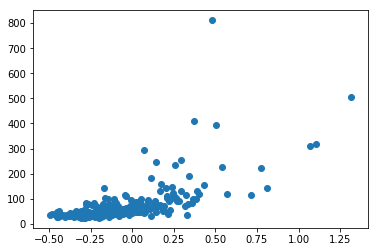

In [124]:
plt.scatter(x=data_pivot_50['price_2'], y=data_pivot_50['avg_agi'])

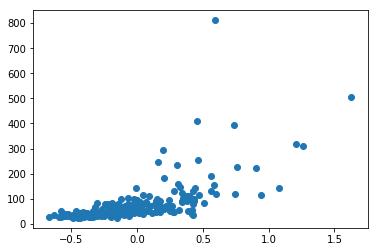

In [125]:
plt.scatter(x=data_pivot_50['price_sc'], y=data_pivot_50['avg_agi'])

In [106]:
from sklearn.linear_model import LinearRegression

In [126]:
lr = LinearRegression()

In [128]:
lr.fit(data_pivot_50[['price_2']], data_pivot_50['avg_agi'])
print(lr.score(data_pivot_50[['price_2']], data_pivot_50['avg_agi']))

0.43045282538684915


In [129]:
lr.fit(data_pivot_50[['price_sc']], data_pivot_50['avg_agi'])
print(lr.score(data_pivot_50[['price_sc']], data_pivot_50['avg_agi']))

0.41395180035664897


In [ ]:
# https://towardsdatascience.com/custom-transformers-and-ml-data-pipelines-with-python-20ea2a7adb65
# https://stackoverflow.com/questions/44408861/

class CategoryPricer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        cvect = CountVectorizer()
        sc = StandardScaler()
        
        categories = cvect.get_feature_names()
        
        C = pd.DataFrame(cvect.fit_transform(X['categories']).toarray(),
                         columns=categories)
        C.replace(0, np.NaN, inplace=True)
        
        S = pd.DataFrame(sc.fit_transform(C),
                         columns=categories)
        
        
        
        X = X.drop('categories', axis=1)
        X = X.join(C)

In [3]:
data[data['zip_code'] == 92845]

,alias,categories,city,id,latitude,longitude,price,rating,review_count,zip_code,avg_agi
28475,a-bite-of-jersey-garden-grove-2,"['cheesesteaks', 'sandwiches', 'chicken_wings']",Garden Grove,Gr4TtbfG10vmgOkFdnadYw,33.780935,-118.041427,1,4.0,161.0,92845,72.275806


In [4]:
DESCRIBE = data.describe()
DESCRIBE

,latitude,longitude,price,rating,review_count,zip_code,avg_agi
count,28476.000000,28476.000000,28476.000000,28476.000000,28476.000000,28476.000000,28476.000000
mean,34.048928,-118.242851,1.479913,3.586792,242.074062,90819.865290,75.439776
std,0.160146,0.204438,0.576493,0.812550,420.322936,773.298386,73.385458
min,33.167953,-119.174788,1.000000,0.000000,0.000000,90001.000000,23.390537
25%,33.948473,-118.385123,1.000000,3.000000,37.000000,90064.000000,39.288225
50%,34.051688,-118.263453,1.000000,4.000000,108.000000,90701.000000,55.424814
75%,34.131785,-118.122028,2.000000,4.000000,281.000000,91361.000000,85.202214
max,34.857667,-117.225868,4.000000,5.000000,16662.000000,93591.000000,811.582132


In [5]:
MEAN = DESCRIBE.loc['mean', 'price']
STDEV = DESCRIBE.loc['std', 'price']

In [6]:
def businesss_scaler(df, zipcode):
    
    mean = df[df['zip_code'] == zipcode]['price'].mean()
    agi = df[df['zip_code'] == zipcode]['avg_agi'].mean()
    
    count = df[df['zip_code'] == zipcode]['price'].count()
    
    z = (mean - MEAN) / STDEV
    
    return z, agi, count

In [7]:
zips = data['zip_code'].unique()
len(zips)

340

In [8]:
prices = []
agis = []
zs = []
    
for z in zips:
    x, y, c = businesss_scaler(data, z)
    if c > 50:
        prices.append(x)
        agis.append(y)
        zs.append(z)

In [9]:
prices

[-0.0965674455466888,
 -0.28973359270446297,
 0.24912085516184282,
 0.008876132727982829,
 0.11590084988737036,
 0.2571197196634542,
 0.7615110420216531,
 -0.02456140354353931,
 0.24271193236451424,
 -0.16013370960342266,
 0.0852036777758422,
 0.004936244008095692,
 -0.3916251319162794,
 -0.3029519210944526,
 0.003868124825918409,
 0.902156357036994,
 -0.2781043277309178,
 -0.15504146450829975,
 1.0803070893897588,
 0.40234899463784507,
 0.024136015974146014,
 0.4034515108784311,
 0.09606565940985443,
 0.02227383073329161,
 0.1457031088592459,
 -0.14668699989911357,
 0.2735001167670814,
 0.3405869337743022,
 -0.4459982169442525,
 -0.5458788862513848,
 -0.013340461998048498,
 0.3155680061678592,
 0.34536297002152927,
 -0.5170827308450816,
 -0.055501499716767606,
 0.4618283323351192,
 0.41787003545286766,
 -0.3867667960781319,
 -0.010371776877705538,
 -0.26252079920909044,
 -0.17767676795937573,
 0.24134662299666249,
 0.42410994510821093,
 -0.391462698584333,
 0.3831905157030655,
 -0.089

In [10]:
summary_df = pd.DataFrame()

In [11]:
summary_df['zip_code'] = zs
summary_df['price'] = prices
summary_df['avg_agi'] = agis

In [12]:
summary_df = summary_df.sort_values(by='price')

In [13]:
summary_df.shape

(223, 3)

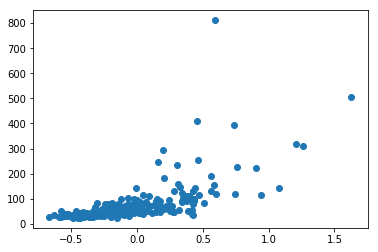

In [14]:
plt.scatter(x=summary_df['price'], y=summary_df['avg_agi'])

In [15]:
df = data.copy()
df.drop(['alias', 'city', 'id'], axis=1, inplace=True)

In [16]:
df['zip_code'] = df['zip_code'].astype(str)

In [17]:
df = df.dropna(axis=0, how='any')

In [25]:
df[df['zip_code'] == '90021']

,categories,latitude,longitude,price,rating,review_count,zip_code,avg_agi
11778,"['mexican', 'bars']",34.039080,-118.240428,2,4.0,1082.0,90021,73.61
11779,['japanese'],34.028189,-118.239372,1,2.0,31.0,90021,73.61
11780,['icecream'],34.031520,-118.236490,2,4.5,42.0,90021,73.61
11781,"['grocery', 'breakfast_brunch', 'markets']",34.036139,-118.231635,2,4.0,335.0,90021,73.61
11782,"['bbq', 'foodstands', 'sandwiches']",34.031520,-118.236490,2,4.5,62.0,90021,73.61
...,...,...,...,...,...,...,...,...
11872,['persian'],34.026611,-118.242798,1,4.0,59.0,90021,73.61
11873,"['italian', 'seafood', 'supperclubs']",34.031496,-118.238998,3,4.0,65.0,90021,73.61
11874,"['mexican', 'foodtrucks']",34.031748,-118.231928,1,4.5,39.0,90021,73.61
11875,"['convenience', 'coffee']",34.026867,-118.238764,1,2.5,12.0,90021,73.61


# use scipy cKDTree to calculate nearest neighbor distances

In [19]:
# https://stackoverflow.com/questions/12923586/
# https://stackoverflow.com/questions/36798782/

coords = df.copy()
coords = coords[['latitude', 'longitude']]

In [20]:
temp_point = list(coords.iloc[4])

In [21]:
# making the tree

distance_tree = cKDTree(coords)

In [22]:
# returns six closest points, including itself
# first array shows distances
# second array appears to show which indices are closest?

_, idx = distance_tree.query(temp_point, k=20)
for i in idx:
    print(data.iloc[i])

alias           yuk-dae-jang-san-gabriel-2
categories                      ['korean']
city                           San Gabriel
id                  DwvljRkxkMEljQBYX-MeTw
latitude                           34.1021
longitude                          -118.11
price                                    2
rating                                 4.5
review_count                           158
zip_code                             91776
avg_agi                             37.211
Name: 4, dtype: object
alias           half-and-half-good-old-time-san-gabriel
categories                   ['taiwanese', 'bubbletea']
city                                        San Gabriel
id                               QhhWJVDP4L805y_YgwM3BQ
latitude                                        34.1021
longitude                                       -118.11
price                                                 1
rating                                                4
review_count                                        209


In [23]:
coords[KDTree(coords).query(list(coords.iloc[0]))[1]]

KeyError: 0

# use CountVectorizer

In [ ]:
X = df[['categories', 'price', 'rating', 'review_count', 'zip_code']]
y = df['avg_agi']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=111)

In [ ]:
cvect = CountVectorizer()

In [ ]:
V_train = cvect.fit_transform(X_train['categories'])

In [ ]:
categories = list(cvect.get_feature_names())

In [ ]:
categories

In [ ]:
V_df = pd.DataFrame(data=V_train.toarray(), columns=categories)

In [ ]:
V_df.shape

In [ ]:
X_train.shape

In [ ]:
X_train = X_train.join(V_df)

In [ ]:
X_train[X_train['zip_code'] == '90001']

In [ ]:
# https://stackoverflow.com/questions/42935334/

X_train.iloc[:, 5:-1] = X_train.iloc[:, 5:-1].mul(X_train.iloc[:, 1], axis=0)

In [ ]:
X_train_nan = X_train.replace(0, np.NaN)

In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [ ]:
X_train_nan.describe().T[X_train_nan.describe().T['count'] > 200].sort_values(by='count', ascending=False)

In [ ]:
X_train_nan.describe().T[X_train_nan.describe().T['count'] > 200].sort_values(by='mean', ascending=False)

In [ ]:
X_train_nan[X_train_nan['zip_code'] == '90001'].describe().T.sort_values(by='mean', ascending=False)

In [ ]:
X_train[X_train['zip_code'] == '90001']

In [ ]:
def numeric_filter(df):
    features = ['price', 'rating', 'review_count']
    return df[features]

Numeric = FunctionTransformer(numeric_filter, validate=False)

In [ ]:
def category_filter(df):
    return df['categories']

Categories = FunctionTransformer(category_filter, validate=False)

In [ ]:
numeric_transformer = Pipeline([
    ('num_filt', Numeric),
    ('poly', PolynomialFeatures()),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('cat_filt', Categories),
    ('cvect', CountVectorizer())
])

In [ ]:
pipe = Pipeline([
    ('union', FeatureUnion([
        ('num', numeric_transformer),
        ('cat', categorical_transformer)
    ])),
    ('rfr', RandomForestRegressor(n_estimators=10,
                                  verbose=1))
])

In [ ]:
pipe.fit_transform(X_train, y_train)

In [ ]:
print(pipe.score(X_train, y_train))
print(pipe.score(X_test, y_test))

In [ ]:
list(pipe.named_steps['rfr'].feature_importances_)

In [ ]:
pipe.named_steps['union'].get_feature_names()

In [ ]:
sns.heatmap(df.corr(),
           annot = True,
           cmap = 'coolwarm')

In [ ]:
plt.figure(figsize=(21, 15))
plt.scatter(df['longitude'], df['latitude'], s=2, alpha=0.2)

# KMeans Clustering

In [ ]:
df._get_numeric_data()

In [ ]:
# Try to pick interesting columns for clustering

sns.pairplot(df._get_numeric_data())

In [ ]:
# Function to create KMeans Clustering for 2 features from original dataframe

def kmean(var1, var2):
    features = [var1, var2]
    X = df[features]

    sc = StandardScaler()
    X = sc.fit_transform(X)

    km = KMeans(n_clusters=3,
           random_state=42)
    km.fit(X)

    df_copy = df.copy()
    df_copy['cluster'] = km.labels_

    print(f' Cluster Centers: \n{km.cluster_centers_}')

    centroids = pd.DataFrame(
        sc.inverse_transform(km.cluster_centers_),
        columns = features
    )

    print(f' Centroids for Plot: \n{centroids}')


    # Visualizing Clusters
    plt.figure(figsize=(7,7));

    ## Plot scatter by cluster / color, and centroids
    colors = ["red", "green", "blue"]
    df_copy['color'] = df_copy['cluster'].map(lambda p: colors[p])

    ax = df.plot(    
        kind="scatter", 
        x=var1, y=var2,
        figsize=(10,8),
        c = df_copy['color']
    )

    centroids.plot(
        kind="scatter", 
        x=var1, y=var2, 
        marker="*", c=["r", "g", "b"], s=550,
        ax=ax
    );

In [ ]:
kmean('latitude', 'longitude')

In [ ]:
kmean('longitude', 'zip_code')

In [ ]:
kmean('latitude', 'zip_code')

# Linear Regression Model
- Only price, rating, dummied zip_code as features.
- Target: ave_agi

In [ ]:
df['zip_code'] = df['zip_code'].astype(int).astype(str)

In [ ]:
df_dummied_city = pd.get_dummies(data=df,columns=['zip_code'])

In [ ]:
df_dummied_city._get_numeric_data().head(2)

In [ ]:
features = df_dummied_city._get_numeric_data().drop(columns=['ave_agi', 'review_count', 'latitude', 'longitude', 'price*rating'])

X = features
y = df_dummied_city['ave_agi']


X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                   random_state = 42)

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
x_test = sc.transform(X_test)

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

In [ ]:
lr.score(X_train, y_train)

In [ ]:
lr.score(X_test, y_test)

In [ ]:
cross_val_score(lr, X_train, y_train, cv = 5).mean()

# Linear Regression Model
- This was really really really bad - Aerika

In [ ]:
df_dummied_city = pd.get_dummies(data=df,columns=['city'])

In [ ]:
df_dummied_city.head(2)

In [ ]:
features = df_dummied_city._get_numeric_data().drop(columns=['ave_agi'])

X = features
y = df_dummied_city['ave_agi']


X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                   random_state = 42)

sc = StandardScaler()

X_train = sc.fit_transform(X_train)
x_test = sc.transform(X_test)

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

In [ ]:
lr.score(X_train, y_train)

In [ ]:
lr.score(X_test, y_test)

In [ ]:
cross_val_score(lr, X_train, y_train, cv = 5).mean()

Jerry's code from previous project, trying to use it to perform a bunch of different models for this project  
Still need to tweak functions so they can be used for this project.

In [ ]:
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.preprocessing import StandardScaler, PowerTransformer, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [ ]:
# numeric columns that seem like continuous features.
numeric_features = ['price', 'rating', 'review_count', 'ave_agi']

# columns that should get dummied out
categorical_features = ['zip_code']

In [ ]:
# transforms numeric columns
# just comment out whichever transformers you want to leave out

numeric_transformer = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False, 
                                interaction_only=False)),
    ('power', PowerTransformer()),
#     ('imputer', SimpleImputer(strategy=)),
    ('scaler', StandardScaler())
])

In [ ]:
# transforms categorical columns into dummy columns

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [ ]:
filter_transformer = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

In [ ]:
# put alias as keys to dictionary
# put instantiation of model, including parameters you don't want to gridsearch, as value

est_dict = {
    'logreg': LogisticRegression(solver='lbfgs'),
    'knn': KNeighborsClassifier(),
    'rand': RandomForestClassifier(n_estimators=100, random_state=111),
    'extra': ExtraTreesClassifier(n_estimators=100, random_state=111),
    'ada': AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=111)
}

# list of aliases so we can loop through models
estimators = ['logreg', 'knn', 'rand', 'extra', 'ada']

In [ ]:
'''
to access parameters, follow this format:

grid_params = {'filter__num__poly__param': [],
    'estimatoralias__param': []
    }
'''

pipe = Pipeline([
    ('filter', filter_transformer),
    ('estimator', Estimator())
])